In [2]:
pip install catboost

     --------------------------------------- 74.0/74.0 MB 14.5 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [82]:
import pandas as pd
import warnings
import pyodbc
warnings.filterwarnings("ignore")
from catboost import CatBoostRegressor
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler    
# from pivottablejs import pivot_ui

In [83]:
server = '10.0.1.40' 
database = 'Ntier_EPIC' 
username = 'Sisenseuser' 
password = '!w@ntd@t@#123'  
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [ ]:
yrs = [('2017-01-01','2017-12-31'),('2018-01-01','2018-12-31'),('2019-01-01','2019-12-31'),('2020-01-01','2020-12-31'),
       ('2021-01-01','2021-12-31'),('2022-01-01','2023-03-05')]
df_list = []
for yr in yrs:
    query = """ Select distinct t1.Service_ID,t1.Patient_ID,t1.Patient_Number,d.IMREDEM_CODE,t5.patient_age,t1.Actual_Dr_Name,
                t1.Place_of_Service_Abbr,t1.Proc_Category_Abbr,t1.Type_of_Service_Abbr,t5.patient_zip_code,t5.patient_sex,
                t1.Original_Carrier_Name, t5.Patient_City, t5.Patient_State,t2.CoPayment,t2.CoInsurance,t1.Primary_Diagnosis_Code,t1.Procedure_Code,
                t1.Service_Units,convert(Date, t1.Service_Date_From) as Service_Date_From, t1.Claim_Number,
                convert(Date, t1.Original_Billing_Date) as Original_Billing_Date,Convert(Date, t2.Date_Paid) as Date_Paid,
                t1.Service_Fee,t2.Amount, t2.Allowed, t2.Deductible, t2.Transaction_Type, t4.Abbreviation,t4.Description, 
                t4.Self_Pay_TranCode
from PM.vwGenSvcInfo as T1
left join PM.[vwGenSvcPmtInfo] T2 ON T1.Service_Id=T2.Service_Id 
left join PM.Reimbursement_Detail T3 on T1.Service_Id=T3.Service_Id
left join [dbo].[vUAI_Transaction_Codes] T4 ON T2.Transaction_Code_Abbr=T4.Abbreviation
left join [EMR].[HPSITE].[DEMOGRAPHICS_VIEW] as d on t1.Patient_Number = d.DEM_EXTERNALID
left join PM.vwGenPatInfo as T5 ON T1.Patient_Number=T5.Patient_Number

where (T1.Service_Date_From between '{}' and '{}') And (T4.Self_Pay_TranCode=0)
and (T4.Description not like '%Self%' And T4.Description not like '%Adj%') And (T2.Transaction_Type !='A') and 
(T2.Transaction_Type !='T') and (T2.Transaction_Type !='B') and (T1.Service_Fee >0)  and (t2.Amount >0) and
((t1.Primary_Diagnosis_Code between 'E08' and 'E13') OR (t1.Primary_Diagnosis_Code='R73.03'));""".format(yr[0],yr[1])
    
    df= pd.read_sql(query,cnxn)
    df_list.append(df)

In [ ]:
data1 = pd.concat(df_list)
data1.head() 

In [56]:
data=data1
data.shape

(78423, 31)

In [57]:
data=data.drop(["IMREDEM_CODE", "Patient_ID"], axis=1)
data=data.drop_duplicates()
data = data.loc[data["Original_Billing_Date"].notna()]
data=data.loc[data["Date_Paid"].notna()]
data["Original_Billing_Date"] = pd.to_datetime(data["Original_Billing_Date"])      
data["Date_Paid"] = pd.to_datetime(data["Date_Paid"]) 
data["Delay_in_days"] = pd.to_datetime(data["Date_Paid"]) - pd.to_datetime(data["Original_Billing_Date"])
data["Delay_in_days"] = data["Delay_in_days"].apply(lambda x: int(str(x).split(" ")[0]))
data_df=data[data['Delay_in_days'] >= 0] 
data_df.head()

,Service_ID,Patient_Number,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,...,Date_Paid,Service_Fee,Amount,Allowed,Deductible,Transaction_Type,Abbreviation,Description,Self_Pay_TranCode,Delay_in_days
0,55285,279220,71,Ashleigh Finazzo PA,EPIC D,LAB CHEM,LAB,48235,M,Medicare Mr,...,2017-01-26,20.00,13.05,NaN,NaN,P,MRPMT,Medicare Payment,False,15
2,304616,287860,42,Antonia Navarro,EP Fer,MEDICAL,MEDICAL,48235,F,Aetna(Medicaid) Better Health of Mi,...,2017-11-29,126.49,36.85,36.85,NaN,P,MDPMT,Medicaid Payment,False,14
3,218677,361840,65,Amanda zzMarcozzi,EP Fer,EVALMGMT,MEDICAL,48030,M,Total Health/ Medicaid,...,2018-06-14,156.00,54.34,54.34,NaN,P,MDPMT,Medicaid Payment,False,306
4,129002,000856,62,Robert C Levine,EP Fer,LAB CHEM,LAB,48220,M,Bcn,...,2017-05-12,6.00,3.48,3.48,NaN,P,BCNPAY,BCN Payment,False,28
5,299561,295560,56,Joshua A Ruedisueli PA,EP Fer,LAB CHEM,LAB,48221,M,Blue Cross Complete (Medicaid),...,2018-10-29,35.00,12.01,12.01,NaN,P,MDPMT,Medicaid Payment,False,355


In [1]:
# Score Derivation
data_df1=data_df[data_df["Service_Fee"] >= data_df["Amount"]]
data_df1["Payment_portion"] = data_df1["Amount"] / data_df1["Service_Fee"]
data_df1["Decay"] = (1 - (data_df1["Delay_in_days"] / 365))   
data_df1["Actual_decay"] = data_df1["Decay"].apply(lambda x: max(0, x))
data_df1["Score"] = data_df1["Actual_decay"] * data_df1["Payment_portion"] 
data_df1.head() 

NameError: name 'data_df' is not defined

In [59]:
df_by_service=data_df1.groupby(["Service_ID"], as_index=False).agg({

        "Patient_Number": "first",
        'patient_age': "max",
        'Actual_Dr_Name': 'first',
        'Place_of_Service_Abbr': 'first',
        'Proc_Category_Abbr': 'first',
        'Type_of_Service_Abbr': 'first',
        'patient_zip_code': "first",
        'patient_sex': "first",
        'Original_Carrier_Name': "first",
        'Patient_City': "first",
        'Patient_State': "first",
        #"Diagnosis_Code": 'first',
        "Description": "first",
        'CoInsurance': "sum",
        'CoPayment': "sum",
        "Primary_Diagnosis_Code": "first",
        "Procedure_Code": "first",
        'Service_Units': "max",   #sum
        'Service_Date_From': "first",
        # "Claim_Number": "first", 
        "Original_Billing_Date": "first",
        "Date_Paid": 'last',
        "Service_Fee": "max",
        "Amount": "sum",   #max
        'Allowed': 'max',
        'Delay_in_days':'max',
        'Actual_decay':'mean',  # Newly added
        'Deductible': 'max',
        "Transaction_Type": "count",   
        "Score": 'mean'    # sum
    })


In [62]:
df_by_service1=df_by_service[df_by_service.Amount <= df_by_service.Service_Fee]
df_by_service1.shape

(72180, 29)

In [63]:
#df_by_service1.to_excel("D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/Ml_model_aggregated_data.xlsx", index = False)
x=df_by_service1

In [64]:
x["Original_Carrier_Name"] = x["Original_Carrier_Name"].astype("category")
x["Primary_Diagnosis_Code"] = x["Primary_Diagnosis_Code"].astype("category")
x["Procedure_Code"] = x["Procedure_Code"].astype("category")
x["Service_ID"] = x["Service_ID"].astype("category")
x["Actual_Dr_Name"] = x["Actual_Dr_Name"].astype("category")
x["Place_of_Service_Abbr"] = x["Place_of_Service_Abbr"].astype("category")
x["Proc_Category_Abbr"] = x["Proc_Category_Abbr"].astype("category")
x["Type_of_Service_Abbr"] = x["Type_of_Service_Abbr"].astype("category")
x["patient_zip_code"] = x["patient_zip_code"].astype("category")
x["patient_sex"] = x["patient_sex"].astype("category")
x["Patient_City"] = x["Patient_City"].astype("category")
x["Patient_State"] = x["Patient_State"].astype("category")
#x["Diagnosis_Code"] = x["Diagnosis_Code"].astype("category")
x["Description"] = x["Description"].astype("category")
x["Service_Date_From"] = pd.to_datetime(x["Service_Date_From"])
#x["Claim_Number"] = x["Claim_Number"].astype("category")
x["Original_Billing_Date"] = pd.to_datetime(x["Original_Billing_Date"])
x["Date_Paid"] = pd.to_datetime(x["Date_Paid"])
x["Patient_Number"] = x["Patient_Number"].astype("category")

In [65]:
# Drop deductible and Patient Number column
x = x.drop(["Deductible","Date_Paid", "Original_Billing_Date", "Service_Date_From"], axis=1)  
x = x[x["CoInsurance"] >= 0]

In [66]:
# Scale the target variable
col_names = ['Score']
features = x[col_names]
scaler = MinMaxScaler(feature_range=(0, 1))
x[col_names] = scaler.fit_transform(features.values)
column_name = 'Original_Carrier_Name'
x.dropna(subset=[column_name], inplace=True)
y = x.Score
X = x.drop(["Score"], axis=1)

In [67]:
# # Take the numeric attributes and remove the outliers
# num_attr = X.select_dtypes(["int64", "float64"]).columns.tolist()
# cat_attr = X.select_dtypes(["category"]).columns.tolist()

# # Clip the outliers
# X[num_attr] = X[num_attr].apply(lambda x: x.clip(x.quantile(0.05), x.quantile(0.95)))

# # Take numeric and categorical attributes column
# cat_att_col = X.select_dtypes(["object", "category"]).columns.tolist()
# num_att_col = X.select_dtypes(["int64", "float64"]).columns.tolist()

# Drop service_id and few more columns
X = X.drop(["Delay_in_days","Actual_decay","Amount","CoPayment","CoInsurance","Transaction_Type"], axis=1)

# Fill the allowed column to be 0
X["Allowed"] = X["Allowed"].fillna(0) 

In [70]:
X.shape, y.shape

((71903, 18), (71903,))

In [71]:
X.columns           

Index(['Service_ID', 'Patient_Number', 'patient_age', 'Actual_Dr_Name',
       'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr',
       'patient_zip_code', 'patient_sex', 'Original_Carrier_Name',
       'Patient_City', 'Patient_State', 'Description',
       'Primary_Diagnosis_Code', 'Procedure_Code', 'Service_Units',
       'Service_Fee', 'Allowed'],
      dtype='object')

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [77]:
X_train1=X_train.drop(['Service_ID', 'Patient_Number'], axis=1)
X_test1=X_test.drop(['Service_ID', 'Patient_Number'], axis=1)

In [78]:
# catboost model after removing outliers and attributes
# List of categorical columns
categoricalcolumns = X_train1.select_dtypes(include=["category"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
# Get location of categorical columns
cat_features = [X_train1.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ", cat_features)
cat_features = [int(i) for i in cat_features]

Names of categorical columns :  ['Actual_Dr_Name', 'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Original_Carrier_Name', 'Patient_City', 'Patient_State', 'Description', 'Primary_Diagnosis_Code', 'Procedure_Code']
Location of categorical columns :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [81]:
X_train1.columns

Index(['patient_age', 'Actual_Dr_Name', 'Place_of_Service_Abbr',
       'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code',
       'patient_sex', 'Original_Carrier_Name', 'Patient_City', 'Patient_State',
       'Description', 'Primary_Diagnosis_Code', 'Procedure_Code',
       'Service_Units', 'Service_Fee', 'Allowed'],
      dtype='object')

In [80]:
from catboost import Pool
# Creating pool object for train dataset. we give information of categorical features to parameter cat_features
# Creating pool object for train dataset. we give information of categorical features to parameter cat_features
train_data = Pool(data=X_train1,
                  label=y_train,
                  cat_features=cat_features
                  )
# Creating pool object for test dataset
test_data = Pool(data=X_test1,
                 label=y_test,
                 cat_features=cat_features
                 )

# build model
print("model is training...")
print("----------------------")
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=False)
# Fit model
cat_model.fit(train_data)
print("Training completed...")
print("----------------------")

# Prediction on train and test
y_train_pred = cat_model.predict(X_train1)
y_test_pred = cat_model.predict(X_test1)
print("----------------------")
print("Results and performance on the training and testing data")
print("----------------------")
print("Training performance")
mean_sq_error = mean_squared_error(y_train, y_train_pred)
print("Mean squared error {:.2f}".format(mean_sq_error))
print("----------------------")
print("Testing performance")
mean_sq_error = mean_squared_error(y_test, y_test_pred)
print("Mean squared error {:.2f}".format(mean_sq_error))
pickle.dump(cat_model, open(r"D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/catboost_model1.pkl", 'wb'))

model is training...
----------------------
Training completed...
----------------------
----------------------
Results and performance on the training and testing data
----------------------
Training performance
Mean squared error 0.00
----------------------
Testing performance
Mean squared error 0.00


In [113]:
from sklearn.metrics import mean_squared_error

# Printing the predicted and actual values on the training data
print("Training set:")
print("Predicted values:", y_train_pred[y_train_pred > 0.90][:10])
print("Actual values:", y_train[y_train > 0.90][:10])

mse_train = mean_squared_error(y_train, y_train_pred)
print("Mean squared error:", mse_train)  

Training set:
Predicted values: [1.00721885 0.91215197 0.91553209 0.92066843 0.90166145 0.90869214
 0.95896416 0.91185059 0.92612459 0.90294651]
Actual values: 4823     0.986188
3124     0.934671
4696     0.906243
22519    0.900371
3847     0.967243
5706     0.914033
9647     0.919724
5064     0.901050
9928     0.921394
15955    0.912017
Name: Score, dtype: float64
Mean squared error: 0.003922939190851713


In [136]:
mae_test = mean_absolute_error(y_test, y_test_pred)
print("Mean absolute error:", mae_test)  

Mean absolute error: 0.038207990180617865


In [153]:
from sklearn.metrics import r2_score
rsquare_test = r2_score(y_test, y_test_pred)
print("R square error:", rsquare_test)  

R square error: 0.8585921291309208


In [157]:
rsquare_train = r2_score(y_train, y_train_pred)
print("R square error:", rsquare_train) 

R square error: 0.8872460595145226


In [144]:
actual_preds = pd.DataFrame({'actuals':y_train, 'pred':y_train_pred})
actual_preds.head()

,actuals,pred
17629,0.501906,0.492200
66619,0.536298,0.519377
21698,0.489282,0.489226
21392,0.135990,0.149012
27912,0.323653,0.304916


In [145]:
actual_preds['error'] = abs(actual_preds.actuals - actual_preds.pred)
actual_preds.head()

,actuals,pred,error
17629,0.501906,0.492200,0.009706
66619,0.536298,0.519377,0.016922
21698,0.489282,0.489226,0.000056
21392,0.135990,0.149012,0.013022
27912,0.323653,0.304916,0.018737


In [147]:
actual_preds.shape

(57297, 3)

In [151]:
actual_preds[actual_preds.error>0.1]

,actuals,pred,error
16254,0.148980,0.297608,0.148629
66136,0.847644,0.653319,0.194325
3763,0.180182,0.412837,0.232655
64094,0.511061,0.306048,0.205013
14307,0.243944,0.405437,0.161493
...,...,...,...
51744,0.139863,0.266624,0.126761
52562,0.008398,0.485675,0.477277
70920,0.662983,0.770366,0.107383
15939,0.238303,0.443333,0.205030


In [131]:
y_test_90 = y_test.reset_index()
y_test_90.rename(columns={'index':'original_df_indx'},inplace=True)
y_test_90 = y_test_90[y_test_90.Score > 0.90]

In [132]:
indx_90 = y_test_90.index.tolist()

In [133]:
y_test_90["predicted"] = y_test_pred[indx_90]

In [134]:
y_test_90

,original_df_indx,Score,predicted
70,8044,0.947871,0.848654
96,18325,0.958564,0.914190
114,3020,0.969613,0.718194
161,3377,0.986188,0.640809
218,19350,0.962266,0.913042
...,...,...,...
13573,69080,0.911602,0.500148
13642,4650,0.911602,0.966076
13830,8283,0.919227,0.854320
14166,54937,0.912877,0.828822


In [137]:
mae_test = mean_absolute_error(y_test_90.Score, y_test_90.predicted)
print("Mean absolute error:", mae_test)  

Mean absolute error: 0.11449562227879312


In [154]:
rsquare_test = r2_score(y_test_90.Score, y_test_90.predicted)
print("R square error:", rsquare_test)  

R square error: -30.690289808700797


In [139]:
y_test_30_40 = y_test.reset_index()
y_test_30_40.rename(columns={'index':'original_df_indx'},inplace=True)
y_test_30_40 = y_test_30_40[(y_test_30_40.Score > 0.30) & (y_test_30_40.Score < 0.40)]
indx_30_40 = y_test_30_40.index.tolist()
y_test_30_40["predicted"] = y_test_pred[indx_30_40]
y_test_30_40

,original_df_indx,Score,predicted
0,62163,0.389420,0.401699
1,69019,0.361096,0.352322
2,70860,0.369161,0.366668
11,19482,0.308377,0.302214
25,34605,0.348612,0.340800
...,...,...,...
14280,8710,0.362113,0.465159
14283,30142,0.320269,0.637427
14307,5954,0.354675,0.363133
14316,24709,0.308394,0.456325


In [140]:
mae_test = mean_absolute_error(y_test_30_40.Score, y_test_30_40.predicted)
print("Mean absolute error:", mae_test) 

Mean absolute error: 0.026264771946760485


In [155]:
rsquare_test = r2_score(y_test_30_40.Score, y_test_30_40.predicted)
print("R square error:", rsquare_test) 

R square error: -1.633763899039545


In [141]:
y_test_10 = y_test.reset_index()
y_test_10.rename(columns={'index':'original_df_indx'},inplace=True)
y_test_10 = y_test_10[y_test_10.Score < 0.10]
indx_10 = y_test_10.index.tolist()
y_test_10["predicted"] = y_test_pred[indx_10]
y_test_10

,original_df_indx,Score,predicted
12,24744,0.099420,0.316352
48,30941,0.064972,0.082080
106,19024,0.079349,0.322763
149,51935,0.053530,0.064548
182,781,0.055534,0.298097
...,...,...,...
14096,2356,0.027594,0.128206
14103,12399,0.000000,0.066551
14171,40079,0.067821,0.064664
14278,36149,0.057576,0.059741


In [142]:
mae_test = mean_absolute_error(y_test_10.Score, y_test_10.predicted)
print("Mean absolute error:", mae_test) 

Mean absolute error: 0.12773399041827077


In [156]:
rsquare_test = r2_score(y_test_10.Score, y_test_10.predicted)
print("R square error:", rsquare_test) 

R square error: -36.90535837670924


In [152]:
# from sklearn.metrics import mean_squared_error

# # Printing the predicted and actual values on the training data
# print("Testing set:")
# pred_df = pd.DataFrame({'actuals':y_test[y_test > 0.90],'predictions':y_test_pred[y_test_pred > 0.90]})
# print(pred_df.head(10))
# # print("Predicted values:", y_test_pred[y_test_pred > 0.90][:10])
# # print("Actual values:", y_test[y_test > 0.90][:10])
# mse_train = mean_squared_error(y_test, y_test_pred)
# print("Mean squared error:", mse_train)   

### Updated Model Evalution Summary

In [ ]:
1. MSE for test data and train dataset is 0.0
2. Mean absolute error for test data is 0.038207.
3. R square error for test data 0.858592 and train data is 0.887246
4. Mean absolute error for test data which Score > 0.9 is  0.11449562227
5. Mean absolute error for test data which Score is between 0.3 to 0.4 is 0.02626477 
6. Mean absolute error for test data which Score < 0.10 is 0.1277339904   

### Existing Model Evalution Summary

In [ ]:
1. MSE for test data and train dataset is 0.0  
2. Mean absolute error for test data is 0.01317.
3. R square error for test data 0.85646 and train data is 0.89573
4. Mean absolute error for test data which Score >0.9 is 0.50573 
5. Mean absolute error for test data which Score is between 0.3 to 0.4 is  0.0589777 
6. Mean absolute error for test data which Score < 0.10 is 0.0083501757354 

In [161]:
pivot_ui(df_by_service1)

#### Old Model Code(Su)

In [2]:
# Patient Data

In [ ]:
import logging

import numpy as np
import pandas as pd
from django.db import connection

# logger = logging.getLogger(__name__)


class PatientData:
    def __init__(self, ml_model_aggregated_data):
        self.logger = logging.getLogger(__name__)
        self.sName = "Recommend Procedure Service"
        self.status = 0
        extra = {
            "cls_name": self.__class__.__name__,
        }
        self.logger = logging.LoggerAdapter(self.logger, extra)

        self.patient_age = None
        self.patient_sex = None
        self.patient_zip_code = None
        self.patient_state = None
        self.diagnosis_codes = None
        self.current_carrier = None
        self.ml_model_aggregated_data = ml_model_aggregated_data
        self.patient_number = None

    def age_gender_loc_similarity(self, df, age_range=3):
        """ Runs demographic similarity checks between
        patients in the input dataframe and the current patient
        :param df: Pandas dataframe with data of patients with the same carrier as current patient
        :param age_range: age difference threshold

        :returns: d3: a filtered input dataframe (df) with matched patient records
        """
        d1 = df[df.age_diff == age_range]
        d2 = d1[d1.patient_sex == self.patient_sex]
        d3 = d2[d2.Patient_State == self.patient_state]
        return d3

    def get_similar_patient_info(self, missing_cpts):
        """
        Finds patients similar to the current patient in terms of
        procedure cods, payer, diagnosis codes, age, gender and location
        :param missing_cpts: Procedure codes that were not performed on the patient in the past
        :return: Dataframe with similar patient records
        """

        if self.current_carrier:
            # Extracting historical data of records for the patient's recent carrier
            result = self.ml_model_aggregated_data[
                self.ml_model_aggregated_data.Original_Carrier_Name == self.current_carrier
            ]

            # Filtering out records where the CPT codes are matching with the missing CPTs
            result_cpt = result[result.Procedure_Code.isin(missing_cpts)]
        else:
            # If the patient data doesn't have carrier name at all
            # use historical data where same diag codes and cpt codes were used
            result = self.ml_model_aggregated_data[
                self.ml_model_aggregated_data.Diagnosis_Code.isin(self.diagnosis_codes)
            ]
            result_cpt = result[result.Procedure_Code.isin(missing_cpts)]

        # Checking if any of the missing CPTs are not present in the current carrier data
        current_carrier_cpts = result_cpt.Procedure_Code.unique().tolist()
        missing_cpt_in_curr_carrier = [p for p in missing_cpts if p not in current_carrier_cpts]

        # If there are missing CPTs in current carrier data, considering historical data for the CPTs irrespective of
        # carrier
        if len(missing_cpt_in_curr_carrier) > 0:
            missing_cpt_result = self.ml_model_aggregated_data[
                self.ml_model_aggregated_data.Procedure_Code.isin(missing_cpt_in_curr_carrier)]
            result_cpt = pd.concat([result_cpt, missing_cpt_result], axis=0)
        # Calculate difference in age between the patient and those in the historical data
        result_cpt.insert(len(result_cpt.columns),'age_diff',abs(result_cpt.patient_age - self.patient_age),True)

        # Iterating over each of the missing CPTs to find similar patient cohort based on age, diag_codes, and location
        cpt_dfs = []
        null_cpts = []

        for cpt in missing_cpts:
            cpt_df = result_cpt[result_cpt.Procedure_Code == str(cpt)]
            if cpt_df.empty:

                # There are CPTs for which records are getting wiped off in the data cleaning steps.
                # Eg: Service_Fee is always zero for 3 CPTs in the 15 CPT list given by EPIC.
                # There are 44 such CPTs in the diabetes funsd_dataset
                # logging such CPTs here in the null_CPTs list
                null_cpts.append(cpt)
                continue

            diagnosis_codes = [i.strip() for i in self.diagnosis_codes]
            similar_pats = cpt_df.Patient_Number.unique().tolist()

            sim_pat_diag = {}
            # Diagnosis codes of patients with this cpt
            for similar_pat in similar_pats:
                d_codes = cpt_df[cpt_df.Patient_Number == similar_pat].Diagnosis_Code.unique().tolist()
                d_codes = [i.strip() for i in d_codes]
                sim_pat_diag[similar_pat] = d_codes

            # Finding patients with similar diagnosis codes based on maximum no of matching codes
            diag_sim = {}
            for k,v in sim_pat_diag.items():
                sim = len(set(diagnosis_codes) & set(v))
                try:
                    diag_sim[sim].append(k)
                except KeyError:
                    diag_sim[sim] = [k]

            # Sorting the diag code similarity dictionary in descending order
            diag_sim = dict(sorted(diag_sim.items(), reverse=True))

            # Iterating over the diag code dictionary starting with patients with maximum similarity score
            filtered_df = pd.DataFrame()
            for k in diag_sim:
                k_df = cpt_df[cpt_df.Patient_Number.isin(diag_sim[k])]
                # Selected patient list is filtered again for demographic similarity based on age, gender and location
                filtered_df = self.age_gender_loc_similarity(k_df)
                # If demographic similarity is nil for the above selected patients,
                # re-run the iteration on patients with lesser diag_code similarity
                if filtered_df.shape[0] == 0:
                    continue
                else:
                    break
            # In cases where we couldn't find patients with diag similarity
            if filtered_df.shape[0] == 0:
                # First look for only demographic similarity with age difference of +or- 3 years
                filtered_df = self.age_gender_loc_similarity(cpt_df)
                if filtered_df.shape[0] == 0:
                    # If still no similar records, relax the age difference to +or- 4 years
                    filtered_df = self.age_gender_loc_similarity(cpt_df, age_range=4)
                    if filtered_df.shape[0] == 0:
                        # If still no similar records, relax the age difference to +or- 5 years
                        filtered_df = self.age_gender_loc_similarity(cpt_df, age_range=5)
                        if filtered_df.shape[0] == 0:
                            # If still no similar records, consider whatever records are available
                            filtered_df = cpt_df
            cpt_dfs.append(filtered_df)

        if len(cpt_dfs) == 0:
            similar_patient_data = pd.DataFrame()
        else:
            # Combine all the similar patient records relating to all missing CPTs
            similar_patient_data = pd.concat(cpt_dfs, axis=0)
            similar_patient_data.drop(['age_diff'], axis='columns', inplace=True)

        return similar_patient_data, null_cpts

    def get_historical_data(self, patient_id):
        """
        this function will fetch the all records
        for the given patient id
        :param int patient_id:
        :return: a dataframe
        """
        result_dict = {"response_key": "-1"}
        try:

            cursor = connection.cursor()
            cursor.execute("""
            select t1.Service_ID,t1.Patient_ID,t1.Patient_Number,d.IMREDEM_CODE,
            t3.patient_age, t1.Actual_Dr_Name,t1.Place_of_Service_Abbr,t1.Proc_Category_Abbr,
            t1.Type_of_Service_Abbr,t3.patient_zip_code,t3.patient_sex,t1.Original_Carrier_Name, t3.Patient_City,
            t3.Patient_State, t5.Diagnosis_Code, t5.Diagnosis_Descr,t2.CoPayment,t2.CoInsurance,
            t1.Primary_Diagnosis_Code,t1.Procedure_Code,t1.Service_Units,
            convert(Date, t1.Service_Date_From) as Service_Date_From, t1.Claim_Number,
            convert(Date, t1.Original_Billing_Date) as Original_Billing_Date,Convert(Date, t2.Date_Paid) as Date_Paid,
            t1.Service_Fee,t2.Amount, t2.Allowed, t2.Deductible, t2.Transaction_Type, t4.Abbreviation ,
            t4.Description, t4.Self_Pay_TranCode
            from  vwGenSvcInfo as t1 left join vwGenSvcPmtInfo as t2
            on t1.Service_ID = t2.Service_ID
            left join
            vwGenSvcDiagInfo as t5 on t1.Service_ID = t5.Service_ID
            left join
            [EMR].[HPSITE].[DEMOGRAPHICS_VIEW] as d on t1.Patient_Number = d.DEM_EXTERNALID
            left join vwGenPatInfo as t3 on t1.Patient_Number = t3.Patient_Number
            left join [dbo].[vUAI_Transaction_Codes] as t4 on t2.Transaction_Code_Abbr=t4.Abbreviation
            left join  dbo.[vUAI_Appointments] as t6 on t1.Voucher_Number = t6.Encounter_Number
            where  t1.Primary_Diagnosis_Code between 'E08' and 'E13' and
             t5.Diagnosis_Code between 'E08' and 'E13' and t1.Patient_ID= %s """, (patient_id,))

            result = pd.DataFrame([list(elem) for elem in cursor.fetchall()])
            if result.empty:
                result = pd.DataFrame()
                raise Exception('No Records Found for Patient')
            else:
                result.columns = ["Service_ID", "Patient_ID", "Patient_Number", "IMREDEM_CODE",
                                  "patient_age", "Actual_Dr_Name", "Place_of_Service_Abbr", "Proc_Category_Abbr",
                                  "Type_of_Service_Abbr", "patient_zip_code", "patient_sex", "Original_Carrier_Name",
                                  "Patient_City", "Patient_State", "Diagnosis_Code", "Diagnosis_Descr",
                                  "CoPayment", "CoInsurance", "Primary_Diagnosis_Code", "Procedure_Code",
                                  "Service_Units", "Service_Date_From", "Claim_Number",
                                  "Original_Billing_Date", "Date_Paid", "Service_Fee", "Amount", "Allowed",
                                  "Deductible", "Transaction_Type", "Abbreviation", "Description", "Self_Pay_TranCode"]

            self.logger.info("result == " + str(result))

        except Exception as e:
            self.logger.info("No Records ", e)
            result = pd.DataFrame()

        return result

    def preprocessing_historical_data(self, one_patient_data):
        """
                This function returns the one patient's pre-processed data
                :param one_patient_data:
                :return: return aggregation of preprocessed data of the patient in dataframe
                """
        # Updating instance variables with the patient information
        self.patient_age = one_patient_data.patient_age.max()
        self.patient_sex = one_patient_data.patient_sex.iloc[0]
        self.patient_zip_code = one_patient_data.patient_zip_code.iloc[0]
        self.patient_state = one_patient_data.Patient_State.iloc[0]
        self.diagnosis_codes = one_patient_data.Diagnosis_Code.unique().tolist()
        self.patient_number = one_patient_data["Patient_Number"].iloc[0]

        # Finding most recent payer
        if not one_patient_data['Original_Carrier_Name'].isnull().all():

            one_patient_data.Service_Date_From = pd.to_datetime(one_patient_data.Service_Date_From)
            sort_values = one_patient_data.groupby(['Original_Carrier_Name'], as_index=False).agg(
                {'Service_Date_From': 'max'})
            self.current_carrier = sort_values.Original_Carrier_Name.iloc[0]

        # Dropping rows where Description contains Self word
        one_patient_data["Description"] = one_patient_data["Description"].apply(lambda x: -999 if str(x).startswith("Self") else x)
        self_pay_index = one_patient_data.loc[one_patient_data["Description"] == -999].index
        one_patient_data = one_patient_data.drop(self_pay_index)
        list_of_col_drop = ["Self Pay Transfer", "Self Pay Adjustment", "Self Pay Financial Hardship"]
        one_patient_data = one_patient_data[~one_patient_data.Description.isin(list_of_col_drop)]

        # drop IMREDEM_COE and Patient_ID keep only Patient_Number
        one_patient_data = one_patient_data.drop(["IMREDEM_CODE", "Patient_ID"], axis=1)

        # Drop duplicate rows
        one_patient_data = one_patient_data.drop_duplicates()  #

        # Drop rows where transaction type is 'T'
        index_names = one_patient_data[
            (one_patient_data['Transaction_Type'] == 'T') & (one_patient_data['Amount'] > 0)].index
        one_patient_data.drop(index_names, inplace=True)

        # Aggregation required to create a uniqueness of the data records
        # Grouping by Service_IDs and later by Patient_Number
        agg1 = one_patient_data.groupby(["Service_ID"], as_index=False).agg({

            "Patient_Number": "first",
            'patient_age': "max",
            'Actual_Dr_Name': 'first',
            'Place_of_Service_Abbr': 'first',
            'Proc_Category_Abbr': 'first',
            'Type_of_Service_Abbr': 'first',
            'patient_zip_code': "first",
            'patient_sex': "first",
            'Original_Carrier_Name': "first",
            'Patient_City': "first",
            'Patient_State': "first",
            "Diagnosis_Code": 'first',
            "Diagnosis_Descr": "first",
            'CoInsurance': "sum",
            'CoPayment': "sum",
            "Primary_Diagnosis_Code": "first",
            "Procedure_Code": "first",
            'Service_Units': "sum",
            'Service_Date_From': "first",
            "Claim_Number": "first",
            "Original_Billing_Date": "first",
            "Date_Paid": 'last',
            "Service_Fee": "max",
            "Amount": "max",
            'Allowed': 'max',
            "Deductible": "max",
            "Transaction_Type": "count",
        })

        agg2 = agg1.groupby(
            ["Patient_Number", "Original_Carrier_Name", "Primary_Diagnosis_Code", "Procedure_Code"],
            as_index=False).agg({

            "Service_ID": "first",
            'patient_age': "max",
            'Actual_Dr_Name': 'first',
            'Place_of_Service_Abbr': 'first',
            'Proc_Category_Abbr': 'first',
            'Type_of_Service_Abbr': 'first',
            'patient_zip_code': "first",
            'patient_sex': "first",
            'Patient_City': "first",
            'Patient_State': "first",
            "Diagnosis_Code": 'first',
            "Diagnosis_Descr": "first",
            'CoInsurance': "sum",
            'CoPayment': "sum",
            'Service_Units': "sum",
            'Service_Date_From': "first",
            "Claim_Number": "first",
            "Original_Billing_Date": "first",
            "Date_Paid": 'last',
            "Service_Fee": "max",
            "Amount": "max",
            'Allowed': 'max',
            "Deductible": "max",
            "Transaction_Type": "count",

        })

        # Filter the records where service fee is greater than 0
        final_df = agg2.loc[agg2["Service_Fee"] > 0]

        # Filter the records where original billing date ad date paid column is coming null
        final_df = final_df.loc[final_df["Original_Billing_Date"].notna()]
        final_df = final_df.loc[final_df["Date_Paid"].notna()]

        return final_df

    def resultant_df(self, patient_data, re_procedure_codes):
        """
        :param patient_data: Pre-processed one-patient data. the output of preprocessing_historical_data method
        :param re_procedure_codes: Procedure codes recommended by the Rule Engine
        :return: Dataframe with current patient records combined with similar patient records if there are CPTS in the
        re_procedure_codes list that were not performed by the patient.
        Else, it returns the current patient records in a dataframe
        """
        # Columns needed for creating input funsd_dataset to the model
        list_of_columns_to_keep = ['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code',
                                   'Procedure_Code',
                                   'patient_age', 'Actual_Dr_Name', 'Place_of_Service_Abbr',
                                   'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex',
                                   'Patient_City', 'Patient_State', 'Diagnosis_Code', 'Diagnosis_Descr', 'CoInsurance',
                                   'CoPayment', 'Service_Units', 'Service_Date_From', 'Claim_Number',
                                   'Original_Billing_Date',
                                   'Date_Paid', 'Service_Fee', 'Amount', 'Allowed', 'Deductible', 'Transaction_Type']

        self.ml_model_aggregated_data = self.ml_model_aggregated_data[list_of_columns_to_keep]

        # drop the duplicates
        self.ml_model_aggregated_data.drop_duplicates(inplace=True)

        # Filter the records where service fee is greater than 0
        self.ml_model_aggregated_data = self.ml_model_aggregated_data.loc[
            self.ml_model_aggregated_data["Service_Fee"] > 0
        ]

        # Filter the records where original billing date ad date paid column is coming null
        self.ml_model_aggregated_data = self.ml_model_aggregated_data.loc[
            self.ml_model_aggregated_data["Original_Billing_Date"].notna()
        ]
        self.ml_model_aggregated_data = self.ml_model_aggregated_data.loc[
            self.ml_model_aggregated_data["Date_Paid"].notna()
        ]

        if patient_data.empty:
            missing_cpts = re_procedure_codes

        else:
            # Find missing CPTs
            cpts_patient_followed = patient_data.Procedure_Code.unique().tolist()
            missing_cpts = [cpt for cpt in re_procedure_codes if cpt not in cpts_patient_followed]

            patient_data = patient_data[list_of_columns_to_keep]
            patient_data = patient_data.reset_index(drop=True)

        if missing_cpts:
            # Finding patients similar to the current patient
            similar_patient_df, null_cpts = self.get_similar_patient_info(missing_cpts)
            if similar_patient_df.shape[0] > 0:

                # aggregation required to create a uniqueness of the data records
                similar_patient_df = similar_patient_df.reset_index(drop=True)
                similar_patient_df = similar_patient_df.groupby(
                    ['Patient_Number',"Original_Carrier_Name", "Primary_Diagnosis_Code", "Procedure_Code"]).agg({

                    'patient_age': "max",
                    'Actual_Dr_Name': 'first',
                    'Place_of_Service_Abbr': 'first',
                    'Proc_Category_Abbr': 'first',
                    'Type_of_Service_Abbr': 'first',
                    'patient_zip_code': "first",
                    'patient_sex': "first",
                    'Patient_City': "first",
                    'Patient_State': "first",
                    "Diagnosis_Code": 'first',
                    "Diagnosis_Descr": "first",
                    'CoInsurance': "sum",
                    'CoPayment': "sum",
                    'Service_Units': "sum",
                    'Service_Date_From': "first",
                    "Claim_Number": "first",
                    "Original_Billing_Date": "first",
                    "Date_Paid": 'last',
                    "Service_Fee": "max",
                    "Amount": "max",
                    'Allowed': 'max',
                    "Deductible": "max",
                    "Transaction_Type": "count",

                }).reset_index()

                # Rearrange the columns as per the ML model input
                similar_patient_df = similar_patient_df.loc[:,
                                ['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code', 'Procedure_Code',
                                 'patient_age', 'Actual_Dr_Name', 'Place_of_Service_Abbr',
                                 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex',
                                 'Patient_City', 'Patient_State', 'Diagnosis_Code', 'Diagnosis_Descr', 'CoInsurance',
                                 'CoPayment', 'Service_Units', 'Service_Date_From', 'Claim_Number', 'Original_Billing_Date',
                                 'Date_Paid', 'Service_Fee', 'Amount', 'Allowed', 'Deductible', 'Transaction_Type']]

                similar_patient_df = similar_patient_df.reset_index(drop=True)

                if patient_data.shape[0] > 0:
                    final_data = patient_data.append(similar_patient_df)
                else:
                    final_data = similar_patient_df
            else:
                final_data = patient_data

        else:
            final_data = patient_data

        final_data = final_data.reset_index(drop=True)

        return final_data

    def data_preparation_model_prediction(self, df, model):
        """
        :param df:
        :param model:
        :return:
        """

        ml_recommendation = dict()
        patient_number = -1
        try:

            df["Patient_Number"] = df["Patient_Number"].astype("category")
            df["Original_Carrier_Name"] = df["Original_Carrier_Name"].astype("category")
            df["Primary_Diagnosis_Code"] = df["Primary_Diagnosis_Code"].astype("category")
            df["Procedure_Code"] = df["Procedure_Code"].astype("category")

            df["Actual_Dr_Name"] = df["Actual_Dr_Name"].astype("category")
            df["Place_of_Service_Abbr"] = df["Place_of_Service_Abbr"].astype("category")
            df["Proc_Category_Abbr"] = df["Proc_Category_Abbr"].astype("category")
            df["Type_of_Service_Abbr"] = df["Type_of_Service_Abbr"].astype("category")
            df["patient_zip_code"] = df["patient_zip_code"].astype("category")
            df["patient_sex"] = df["patient_sex"].astype("category")
            df["Patient_City"] = df["Patient_City"].astype("category")
            df["Patient_State"] = df["Patient_State"].astype("category")
            df["Diagnosis_Code"] = df["Diagnosis_Code"].astype("category")
            df["Diagnosis_Descr"] = df["Diagnosis_Descr"].astype("category")
            df["Service_Date_From"] = pd.to_datetime(df["Service_Date_From"])
            df["Claim_Number"] = df["Claim_Number"].astype("category")
            df["Original_Billing_Date"] = pd.to_datetime(df["Original_Billing_Date"])
            df["Date_Paid"] = pd.to_datetime(df["Date_Paid"])
            patient_number = df.loc[:, "Patient_Number"][0]

            # Drop deductible column
            df = df.drop("Deductible", axis=1)
            # only one record was found were co insurance is less than 0
            # df = df[df["CoInsurance"] >= 0]

            # Create a new feature
            df["Payment_Gap_In_Days"] = df["Date_Paid"] - df["Original_Billing_Date"]
            df["Payment_Gap_In_Days"] = df["Payment_Gap_In_Days"].apply(lambda x: int(str(x).split(" ")[0]))

            # Drop These features
            df = df.drop(["Date_Paid", "Original_Billing_Date", "Service_Date_From"], axis=1)

            # Take the payment gap greater than 0 days
            # df = df[df["Payment_Gap_In_Days"] > 0]

            # Fill the allowed column to be 0
            df["Allowed"] = df["Allowed"].fillna(0)
            df["CoInsurance"] = df["CoInsurance"].fillna(0)

            # convert the data types
            df["Allowed"] = df["Allowed"].astype("float64")
            df["Service_Fee"] = df["Service_Fee"].astype("float64")
            # Derive the new feature payment portion percentage
            df["Payment_portion_percentage"] = ((df["Allowed"] / df["Service_Fee"]) * 100)

            # ML Model inference #
            prediction = model.predict(df)
            prediction = np.absolute(np.round(prediction, 2))
            df = df.reset_index(drop=True)
            df["Predicted_Score"] = pd.Series(prediction, name="Predicted_Score")

            df = df.sort_values(["Predicted_Score"], ascending=False)

            result = df.loc[:, ["Procedure_Code", "Predicted_Score"]]
            # result = result.loc[result["Predicted_Score"] >= 0]

            self.logger.info(result)

            res_dict = dict()
            for col in result.columns:
                res_dict[col] = result[col].values.tolist()
            ml_recommendation[patient_number] = res_dict

        except Exception as e:
            self.logger.exception(str(e))

        return ml_recommendation, patient_number


In [ ]:
## Views

In [ ]:
import logging
import os
import pickle
import time
import warnings
from configparser import ConfigParser

import pandas as pd
from django.conf import settings
from django.http import HttpResponse
from rest_framework.response import Response
from rest_framework.views import APIView

from .Integration import Integration
from .PatientData import PatientData
from .ResponseJson import ResponseJson
from .errorcode import ErrorCodes

warnings.filterwarnings("ignore")

config = ConfigParser()
config.read("config/config.ini")

# Loading historical data from the cleaned aggregated diabetes funsd_dataset excel,
# We could execute a dynamic sql query, but it is taking too much time to pull past 5 year records
model_aggregated_data = pd.read_excel(config["path"]["model_aggregated_data_path"])
epic_rules_data = pd.read_csv(config["path"]["epic_rules_data_path"])

cat_model = pickle.load(
    open("config\\catboost_model1.pkl", "rb"))
log_dir = settings.LOG_DIR


def log_file(self):
    try:
        file_name = "PredictionEngine" + ".log"
        f = open(os.path.join(log_dir, file_name), "r")
        file_contents = f.read()
        f.close()
        return HttpResponse(file_contents, content_type="text/plain")
    except Exception as e:
        return HttpResponse(str(e), content_type="text/plain")


class PredictProcedure(APIView):
    """
        This View takes two numbers as input and does addition of two numbers
        and provides the sum as output
    """

    def __init__(self):
        self.logger = logging.getLogger(__name__)
        self.errorObj = ErrorCodes()
        self.responseObj = ResponseJson()
        self.s_Name = "Prediction Engine Service"
        self.status = 0
        self.patient_id = "-1"
        self.recommended_code = {}
        extra = {
            "cls_name": self.__class__.__name__,
        }
        self.logger = logging.LoggerAdapter(self.logger, extra)

    def post(self, request):
        start_time = time.time()
        request_data = request.data
        # input_request_validation_obj = InputRequestValidation()
        try:
            patient_id = request_data["Patient_ID"]
            rule_engine_recommended_code = request_data["Rule_Engine_Recommended_Code"]
            re_procedure_codes = [str(k) for k, v in rule_engine_recommended_code.items() if v == '1']

            if len(re_procedure_codes) == 0:
                final_recommendation = {-1: {'Proc_code': [], 'Pred_score': []}}
                self.logger.info(
                    "Predict Procedure not started since no cpt recommended by RE for patient id: " + str(patient_id)
                )

            else:

                self.logger.info("Predict Procedure Started = " + str(patient_id))

                # Instantiating the PatientData class from PatientData module
                patient_data = PatientData(model_aggregated_data)

                patient_df = patient_data.get_historical_data(patient_id)
                self.logger.info("patient Data fetched")

                # Passing the single patient df to preprocessing data,
                # preparing data for historically followed procedure code
                aggregated_data_of_one_patient_records = patient_data.preprocessing_historical_data(patient_df)
                self.logger.info("pre processing complete")


                final_df = patient_data.resultant_df(aggregated_data_of_one_patient_records, re_procedure_codes)
                self.logger.info("Resultant DF complete")

                # Passing the final pre-processed funsd_dataset for model inference
                ml_recommendation, patient_number = patient_data.data_preparation_model_prediction(final_df, cat_model)

                self.logger.info("ml recommendation complete")
                self.logger.info(ml_recommendation)

                final_recommendation = Integration().integration(
                    rule_engine_recommended_code,
                    ml_recommendation,
                    patient_id,
                    patient_number
                )

            self.logger.info("Response = " + str(final_recommendation))

            end_time = time.time()
            self.status = 200
            self.patient_id = patient_id
            self.recommended_code = final_recommendation

        except Exception as e:
            end_time = time.time()
            self.logger.exception(e)
            self.status = 210

        if self.status == 200:
            status_msg = self.errorObj.SuccessMsg
        else:
            status_msg = self.errorObj.FailureMsg

        response = self.responseObj.response_json_object(
            self.s_Name + str(self.errorObj.return_error_message(str(self.status))), end_time - start_time, self.status,
            status_msg, str(self.patient_id), str(self.recommended_code))

        return Response(response)

In [ ]:
## Config.ini
[path]

ml_data_path=config/ML_model_data.xlsx
epic_rules_data_path=config/epic_rules_data.csv
model_aggregated_data_path=config/Ml_model_aggregated_data.xlsx
cat_model_path=config/catboost_model1.pkl

In [ ]:
## Intigration 
import pandas as pd


class Integration:

    def integration(self, rule_engine_recommended_code, ml_recommendation, patient_id, patient_number):
        """takes dictionary, lists, patient id as inputs and returns pandas dataframe"""
        resultant_df = dict()

        re_procedure_code = [k for k, v in rule_engine_recommended_code.items() if v == '1']

        list_val = []
        ml_pro_code = ml_recommendation[patient_number]["Procedure_Code"]
        ml_score = ml_recommendation[patient_number]["Predicted_Score"]

        for k in re_procedure_code:

            if k in ml_pro_code:
                pos = ml_pro_code.index(k)
                sco = ml_score[pos]
                list_val.append([k, sco, 1])
            else:
                list_val.append([k, 0, 1])

        final_proc_codes = pd.DataFrame(list_val, columns=['Proc_code', 'Pred_score', 'Eligibility'])
        final_proc_codes['PatientID'] = patient_id
        final_proc_codes = final_proc_codes.sort_values(by='Pred_score', ascending=False)
        final_proc_codes = final_proc_codes.loc[:, ["Proc_code", "Pred_score"]]
        final_proc_codes = final_proc_codes.reset_index(drop=True)
        res = final_proc_codes.to_dict("list")

        resultant_df[patient_number] = res
        return resultant_df


In [ ]:
#### New Model(Prediabetic Patients)(shiva_Prediction_Engine)

In [ ]:
# Patient Data

import logging
import numpy as np
import pandas as pd
from django.db import connection

logger = logging.getLogger(__name__)


class PatientData:
    def __init__(self):
        self.logger = logging.getLogger(__name__)
        self.sName = "Recommend Procedure Service"
        self.status = 0
        extra = {
            "cls_name": self.__class__.__name__,
        }
        self.logger = logging.LoggerAdapter(self.logger, extra)

    def get_historical_data(self, patient_id):
        """
        this function will fetch the all records
        for the given patient id
        :param int patient_id:
        :return: a dataframe
        """
        result_dict = {"response_key": "-1"}
        try:
            cursor = connection.cursor()
            cursor.execute("""
            Select t1.Service_ID,t1.Patient_ID,t1.Patient_Number,d.IMREDEM_CODE,t5.patient_age,
            t1.Actual_Dr_Name,t1.Place_of_Service_Abbr,t1.Proc_Category_Abbr,t1.Type_of_Service_Abbr,
            t5.patient_zip_code,t5.patient_sex,t1.Original_Carrier_Name, t5.Patient_City, t5.Patient_State,
            t2.CoPayment,t2.CoInsurance,t1.Primary_Diagnosis_Code,t1.Procedure_Code,t1.Service_Units,
            convert(Date,t1.Service_Date_From) as Service_Date_From, t1.Claim_Number,
            convert(Date, t1.Original_Billing_Date) as Original_Billing_Date,Convert(Date, t2.Date_Paid) as Date_Paid,
            t1.Service_Fee,t2.Amount, t2.Allowed, t2.Deductible, t2.Transaction_Type, t4.Abbreviation,
            t4.Description, t4.Self_Pay_TranCode
            from PM.vwGenSvcInfo as t1
            left join PM.[vwGenSvcPmtInfo] t2 ON t1.Service_Id=t2.Service_Id 
            left join PM.Reimbursement_Detail t3 on t1.Service_Id=t3.Service_Id
            left join [dbo].[vUAI_Transaction_Codes] t4 ON t2.Transaction_Code_Abbr=t4.Abbreviation
            left join [EMR].[HPSITE].[DEMOGRAPHICS_VIEW] as d on t1.Patient_Number = d.DEM_EXTERNALID
            left join PM.vwGenPatInfo as t5 ON T1.Patient_Number=T5.Patient_Number
            where t1.Service_Date_From > '2017-01-01' and t4.Self_Pay_TranCode=0 and  
            (t2.Transaction_Type !='A') and (t2.Transaction_Type !='T') and (t2.Transaction_Type !='B') 
            and (t1.Service_Fee > 0) and (t2.Amount >0) and ((t1.Primary_Diagnosis_Code between 'E08' and 'E13') OR 
            (t1.Primary_Diagnosis_Code='R73.03')) and t1.Patient_ID= %s """, (patient_id,))

            result = pd.DataFrame([list(elem) for elem in cursor.fetchall()])

            if not result.empty:
                result.columns = ["Service_ID", "Patient_ID", "Patient_Number", "IMREDEM_CODE", "patient_age",
                                  "Actual_Dr_Name", "Place_of_Service_Abbr", "Proc_Category_Abbr",
                                  "Type_of_Service_Abbr","patient_zip_code", "patient_sex", "Original_Carrier_Name",
                                  "Patient_City", "Patient_State", "CoPayment", "CoInsurance", "Primary_Diagnosis_Code",
                                  "Procedure_Code", "Service_Units", "Service_Date_From", "Claim_Number",
                                  "Original_Billing_Date", "Date_Paid", "Service_Fee", "Amount", "Allowed", "Deductible",
                                  "Transaction_Type", "Abbreviation", "Description", "Self_Pay_TranCode"]

            # self.logger.info("result == " + str(result))
        except Exception as e:
            self.logger.info("Error at Patient History ", e)
            result = {"failed "}
        return result

    def preprocessing_historical_data(self, one_patient_data):
        """
                This function returns the one patient of pre-processed data
                :param one_patient_data:
                :return: return aggregation of preprocessed data of the patient in dataframe
        """
        one_patient_data["Description"] = one_patient_data["Description"].apply(
            lambda x: -999 if str(x).startswith("Self") else x)
        self_pay_index = one_patient_data.loc[one_patient_data["Description"] == -999].index
        one_patient_data = one_patient_data.drop(self_pay_index)
        list_of_col_drop = ["Self Pay Transfer", "Self Pay Adjustment", "Self Pay Financial Hardship"]
        one_patient_data = one_patient_data[~one_patient_data.Description.isin(list_of_col_drop)]

        # drop IMREDEM_COE and Patient_ID keep only Patient_Number
        one_patient_data = one_patient_data.drop(["IMREDEM_CODE", "Patient_ID"], axis=1)

        # Preprocessing
        one_patient_data = one_patient_data.drop_duplicates()
        one_patient_data = one_patient_data.loc[one_patient_data["Original_Billing_Date"].notna()]
        one_patient_data = one_patient_data.loc[one_patient_data["Date_Paid"].notna()]
        one_patient_data["Original_Billing_Date"] = pd.to_datetime(one_patient_data["Original_Billing_Date"])
        one_patient_data["Date_Paid"] = pd.to_datetime(one_patient_data["Date_Paid"])
        one_patient_data["Delay_in_days"] = pd.to_datetime(one_patient_data["Date_Paid"]) - pd.to_datetime(one_patient_data["Original_Billing_Date"])
        one_patient_data["Delay_in_days"] = one_patient_data["Delay_in_days"].apply(lambda x: int(str(x).split(" ")[0]))
        data_df = one_patient_data[one_patient_data['Delay_in_days'] >= 0]
        data_df1 = data_df[data_df["Service_Fee"] >= data_df["Amount"]]
        df_by_service= data_df1.groupby(["Service_ID"], as_index=False).agg({
            "Patient_Number": "first",
            'patient_age': "max",
            'Actual_Dr_Name': 'first',
            'Place_of_Service_Abbr': 'first',
            'Proc_Category_Abbr': 'first',
            'Type_of_Service_Abbr': 'first',
            'patient_zip_code': "first",
            'patient_sex': "first",
            'Original_Carrier_Name': "first",
            'Patient_City': "first",
            'Patient_State': "first",
            "Description": "first",
            'CoInsurance': "sum",
            'CoPayment': "sum",
            "Primary_Diagnosis_Code": "first",
            "Procedure_Code": "first",
            'Service_Units': "max",   #sum
            'Service_Date_From': "first",
            # "Claim_Number": "first",
            "Original_Billing_Date": "first",
            "Date_Paid": 'last',
            "Service_Fee": "max",
            "Amount": "sum",   #max
            'Allowed': 'max',
            'Delay_in_days':'max',
            'Deductible': 'max',
            "Transaction_Type": "count"
        })
        df_by_service1 = df_by_service[df_by_service.Amount <= df_by_service.Service_Fee]
        final_df=df_by_service1
        return final_df

    def patient_procedure_code_followed_not_followed(self, history_records_followed, client_procedure_code):
        """
        :param history_records_followed:
        :param client_procedure_code:
        :return:
        """
        records_followed = history_records_followed
        procedure_code_not_followed = dict()
        patient_id = records_followed["Patient_Number"].tolist()[0]
        followed_procedure_code_list = records_followed["Procedure_Code"].value_counts().keys().tolist()

        not_followed_procedure_code = []

        for proc_code in client_procedure_code:
            if proc_code not in followed_procedure_code_list:
                not_followed_procedure_code.append(proc_code)

        procedure_code_not_followed[patient_id] = not_followed_procedure_code

        patient_age = records_followed["patient_age"].iloc[0]
        patient_zip_code = records_followed["patient_zip_code"].iloc[0]
        return patient_id, patient_age, patient_zip_code, records_followed, procedure_code_not_followed

    def resultant_df(self, final_data, ml_model_aggregated_data, client_procedure_code):
        """
        :param final_data:
        :param ml_model_aggregated_data:
        :param client_procedure_code:
        :return:
        """

        patient_id, patient_age, patient_zip_code, records_followed, procedure_code_not_followed = \
            self.patient_procedure_code_followed_not_followed(final_data, client_procedure_code)
        print(records_followed)
        print(procedure_code_not_followed)

        list_of_columns_to_keep = ['Service_ID','Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code',
                                   'Procedure_Code','patient_age', 'Actual_Dr_Name', 'Place_of_Service_Abbr',
                                   'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex',
                                   'Patient_City', 'Patient_State', 'CoInsurance', 'CoPayment', 'Service_Units',
                                   'Service_Date_From', 'Original_Billing_Date','Date_Paid', 'Service_Fee',
                                   'Amount', 'Allowed', 'Deductible', 'Description', 'Transaction_Type']

        # reading data from the final dataset, Either can execute the query for these aggregated data are
        # of 5 years records so reading it in excel
        list_of_columns_to_keep_df = ml_model_aggregated_data[list_of_columns_to_keep]

        # drop the duplicates
        list_of_columns_to_keep_df = list_of_columns_to_keep_df.drop_duplicates()

        # Remove the white trailing spaces
        list_of_columns_to_keep_df["Primary_Diagnosis_Code"] = list_of_columns_to_keep_df[
            "Primary_Diagnosis_Code"].str.strip()

        # Collect the unique payer name list
        records_followed_payer_name = records_followed["Original_Carrier_Name"].value_counts().keys().tolist()

        # Collect the unique primary diagnosis code in list
        records_followed_primary_diag_name = records_followed[
            "Primary_Diagnosis_Code"].str.strip().value_counts().keys().tolist()

        # Collect the data w.r.t to the payer where one patient is registered(filtering the data w.r.t payer)
        resultant_df = pd.DataFrame()
        for rec in records_followed_payer_name:
            res = list_of_columns_to_keep_df.loc[list_of_columns_to_keep_df["Original_Carrier_Name"] == rec]
            resultant_df = resultant_df.append(res)

        # filtering the data w.r.to diagnosis code where the patient is suffered
        result_df = pd.DataFrame()
        for rec in records_followed_primary_diag_name:
            res = resultant_df.loc[resultant_df["Primary_Diagnosis_Code"] == rec]
            result_df = result_df.append(res)

        # List of procedure code where in the history not performed by the patient
        list_of_procedure_need_to_be_add = procedure_code_not_followed[patient_id]

        # dataframe creation where the procedure code not performed
        semi_final_df = pd.DataFrame()

        for proc in list_of_procedure_need_to_be_add:
            res = result_df.loc[result_df["Procedure_Code"] == proc]
            semi_final_df = semi_final_df.append(res)

        # aggregation required to create a uniqueness of the data records
        semi_final_df = semi_final_df.reset_index(drop=True)
        # Adding the columns where the attributes are required for ML model
        semi_final_df["Patient_Number"] = patient_id
        semi_final_df["patient_age"] = patient_age
        semi_final_df["patient_zip_code"] = patient_zip_code
        # Rearrange the columns as per the ML model input
        semi_final_df = semi_final_df.loc[:,
                        ['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code', 'Procedure_Code',
                         'patient_age', 'Actual_Dr_Name', 'Place_of_Service_Abbr',
                         'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex',
                         'Patient_City', 'Patient_State', 'CoInsurance',
                         'CoPayment', 'Service_Units', 'Service_Date_From', 'Original_Billing_Date',
                         'Date_Paid', 'Service_Fee', 'Amount', 'Allowed', 'Deductible', 'Description', 'Transaction_Type']]

        # Columns need for creating input dataset to the model
        columns_needed_for_df = list_of_columns_to_keep

        records_followed = records_followed[columns_needed_for_df]

        records_followed = records_followed.reset_index(drop=True)
        semi_final_df = semi_final_df.reset_index(drop=True)
        final_df_1 = records_followed.append(semi_final_df)
        final_df_1 = final_df_1.reset_index(drop=True)
        return final_df_1

    def data_preparation_model_prediction(self, df, model):
        """
        :param df:
        :param model:
        :return:
        """
        ml_recommendation = dict()
        patient_number = -1
        try:

            df["Patient_Number"] = df["Patient_Number"].astype("category")
            df["Service_Date_From"] = pd.to_datetime(df["Service_Date_From"])
            df["Original_Billing_Date"] = pd.to_datetime(df["Original_Billing_Date"])
            df["Date_Paid"] = pd.to_datetime(df["Date_Paid"])
            patient_number = df.loc[:, "Patient_Number"][0]

            # drop columns
            df = df.drop(["Service_ID","Patient_Number", "Amount", "Transaction_Type", "Deductible",
                          "Date_Paid", "Original_Billing_Date", "Service_Date_From"], axis=1)
            df = df[df["CoInsurance"] >= 0]
            column_name = 'Original_Carrier_Name'
            df.dropna(subset=[column_name], inplace=True)
            # Fill the allowed column to be 0
            df["Allowed"] = df["Allowed"].fillna(0)
            df = df.drop(["CoInsurance", "CoPayment"], axis=1)
            # convert the data types
            df["patient_age"] = df["patient_age"].astype("int64")
            df["Actual_Dr_Name"] = df["Actual_Dr_Name"].astype("category")
            df["Place_of_Service_Abbr"] = df["Place_of_Service_Abbr"].astype("category")
            df["Proc_Category_Abbr"] = df["Proc_Category_Abbr"].astype("category")
            df["Type_of_Service_Abbr"] = df["Type_of_Service_Abbr"].astype("category")
            df["patient_zip_code"] = df["patient_zip_code"].astype("category")
            df["patient_sex"] = df["patient_sex"].astype("category")
            df["Original_Carrier_Name"] = df["Original_Carrier_Name"].astype("category")
            df["Patient_City"] = df["Patient_City"].astype("category")
            df["Patient_State"] = df["Patient_State"].astype("category")
            df["Description"] = df["Description"].astype("category")
            df["Primary_Diagnosis_Code"] = df["Primary_Diagnosis_Code"].astype("category")
            df["Procedure_Code"] = df["Procedure_Code"].astype("category")
            df["Service_Units"] = df["Service_Units"].astype("float64")
            df["Service_Fee"] = df["Service_Fee"].astype("float64")
            df["Allowed"] = df["Allowed"].astype("float64")
            # Rearrange the columns
            df = df[['patient_age', 'Actual_Dr_Name', 'Place_of_Service_Abbr',
                    'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code',
                     'patient_sex', 'Original_Carrier_Name', 'Patient_City', 'Patient_State',
                     'Description', 'Primary_Diagnosis_Code', 'Procedure_Code', 'Service_Units',
                     'Service_Fee', 'Allowed']]
            if df.empty:
                self.logger.info('patient data empty due to null values in date_paid and/or original_billing_date')
                return ml_recommendation, patient_number
            prediction = model.predict(df)
            prediction = np.round(prediction, 2)
            df = df.reset_index(drop=True)
            df["Predicted_Score"] = pd.Series(prediction, name="Predicted_Score")
            df = df.sort_values(["Predicted_Score"], ascending=False)
            result = df.loc[:, ["Procedure_Code", "Predicted_Score"]]
            result = result.loc[result["Predicted_Score"] >= 0]
            self.logger.info(result)

            res_dict = dict()
            for col in result.columns:
                res_dict[col] = result[col].values.tolist()
            ml_recommendation[patient_number] = res_dict

        except Exception as e:
            self.logger.exception(str(e))
        return ml_recommendation, patient_number


In [ ]:
## View 

import logging
import os
import pickle
import time
import warnings
from configparser import ConfigParser
import pandas as pd
from django.conf import settings
from django.http import HttpResponse
from rest_framework.response import Response
from rest_framework.views import APIView

from .Integration import Integration
from .PatientData import PatientData
from .ResponseJson import ResponseJson
from .errorcode import ErrorCodes
from django.db import connection
from django.db.utils import DataError

warnings.filterwarnings("ignore")

config = ConfigParser()
config.read("config/config.ini")
model_aggregated_data = pd.read_excel(config["path"]["model_aggregated_data_path"])
epic_rules_data = pd.read_csv(config["path"]["epic_rules_data_path"])
cat_model = pickle.load(open(config['path']['cat_model_path'], "rb"))
log_dir = settings.LOG_DIR


def handle_empty_patient_data(patient_id, rule_engine_recommended_code, start_time):

    pred_scores = [0.0] * len(rule_engine_recommended_code)
    rec = {str(patient_id): {'Proc_code': list(rule_engine_recommended_code.keys()),
                             'Pred_score': pred_scores}}

    response = {
        "message": "Prediction Engine Service completed successfully.",
        "status": "Success",
        "statusCode": 200,
        "respTime": time.time() - start_time,
        "patiend_id": str(patient_id),
        "recommended_code": str(rec)
    }

    return response


def log_file(self):
    try:
        file_name = "PredictionEngine" + ".log"
        f = open(os.path.join(log_dir, file_name), "r")
        file_contents = f.read()
        f.close()
        return HttpResponse(file_contents, content_type="text/plain")
    except Exception as e:
        return HttpResponse(str(e), content_type="text/plain")


class PredictProcedure(APIView):
    """
        This View takes two numbers as input and does addition of two numbers
        and provides the sum as output
    """

    def __init__(self):
        self.logger = logging.getLogger(__name__)
        self.errorObj = ErrorCodes()
        self.responseObj = ResponseJson()
        self.s_Name = "Prediction Engine Service"
        self.status = 0
        self.patient_id = "-1"
        self.recommended_code = {}
        extra = {
            "cls_name": self.__class__.__name__,
        }
        self.logger = logging.LoggerAdapter(self.logger, extra)

    def post(self, request):
        start_time = time.time()
        request_data = request.data
        # input_request_validation_obj = InputRequestValidation()
        try:
            patient_id = request_data["Patient_ID"]
            cursor = connection.cursor()
            # query to get count of records with the given patient_id
            query = """SELECT COUNT(1) FROM PM.vwGenSvcInfo WHERE Patient_ID = %s """
            try:
                cursor.execute(query, (patient_id,))
                cursor_out = cursor.fetchone()
                patient_rec_count = cursor_out[0]
            except DataError:
                self.logger.exception("Invalid patient id")
                return Response({"Invalid patient id"}, status=212)

            except Exception as e:
                self.logger.exception(str(e))
                return Response({"DB error"}, status=213)

            if patient_rec_count == 0:
                return Response({"Patient_id does not exist"}, status=210)

            else:
                rule_engine_recommended_code = request_data["Rule_Engine_Recommended_Code"]
                self.logger.info("Predict Procedure Started = " + str(patient_id))

                patient_df = PatientData().get_historical_data(patient_id)
                self.logger.info("patient Data fetched")

                if patient_df.shape[0] == 0:

                    response = handle_empty_patient_data(patient_id, rule_engine_recommended_code, start_time)
                    self.logger.info("patient Data empty. Returning all zero scores for recommended CPTs")

                    return Response(response)

                # Passing the single patient df to preprocessing data,
                # preparing data for historically followed procedure code
                aggregated_data_of_one_patient_records = PatientData().preprocessing_historical_data(patient_df)
                self.logger.info("pre processing complete")

                if aggregated_data_of_one_patient_records.shape[0] == 0:
                    response = handle_empty_patient_data(patient_id, rule_engine_recommended_code, start_time)
                    self.logger.info("patient Data empty after applying pre-processing steps."
                                     " Returning all zero scores for recommended CPTs")

                    return Response(response)

                epic_rules = epic_rules_data["Procedure_Code"].value_counts().keys().tolist()
                epic_rules = [str(code) for code in epic_rules]

                final_df = PatientData().resultant_df(aggregated_data_of_one_patient_records, model_aggregated_data,
                                                      epic_rules)
                self.logger.info("Resultant DF complete")

                ml_recommendation, patient_number = PatientData().data_preparation_model_prediction(final_df, cat_model)
                self.logger.info("ml recommendation complete")
                self.logger.info(ml_recommendation)

                if not ml_recommendation:
                    response = handle_empty_patient_data(patient_id, rule_engine_recommended_code, start_time)
                    self.logger.info("patient Data empty due to nulls in date_paid and/or original_billing_date cols."
                                     " Returning all zero scores for recommended CPTs")
                    return Response(response)

                final_recommendation = Integration().integration(rule_engine_recommended_code, ml_recommendation,
                                                                 patient_id, patient_number)
                self.logger.info("Response = " + str(final_recommendation))
                print(str(final_recommendation))
                end_time = time.time()
                self.status = 200
                self.patient_id = patient_id
                self.recommended_code = final_recommendation

        except Exception as e:
            end_time = time.time()
            self.logger.exception(e)
            self.status = 210

        if self.status == 200:
            status_msg = self.errorObj.SuccessMsg
        else:
            status_msg = self.errorObj.FailureMsg

        response = self.responseObj.response_json_object(
            self.s_Name + str(self.errorObj.return_error_message(str(self.status))), end_time - start_time, self.status,
            status_msg, str(self.patient_id), str(self.recommended_code))

        return Response(response)


In [ ]:
## Intigration
import pandas as pd


class Integration:

    def integration(self, rule_engine_recommended_code, ml_recommendation, patient_id, patient_number):
        """takes dictionary, lists, patient id as inputs and returns pandas dataframe"""
        resultant_df = dict()
        # r73_procs = ['82985','82043']
        re_procedure_code = [k for k, v in rule_engine_recommended_code.items() if v == '1']

        list_val = []
        ml_pro_code = ml_recommendation[patient_number]["Procedure_Code"]
        ml_score = ml_recommendation[patient_number]["Predicted_Score"]

        for k in re_procedure_code:

            # if k in r73_procs:
            # list_val.append([k, 0, 1])
            if k in ml_pro_code:
                pos = ml_pro_code.index(k)
                sco = ml_score[pos]
                list_val.append([k, sco, 1])
            else:
                list_val.append([k, 0, 1])

        final_proc_codes = pd.DataFrame(list_val, columns=['Proc_code', 'Pred_score', 'Eligibility'])
        final_proc_codes['PatientID'] = patient_id
        final_proc_codes = final_proc_codes.sort_values(by='Pred_score', ascending=False)
        final_proc_codes = final_proc_codes.loc[:, ["Proc_code", "Pred_score"]]
        final_proc_codes = final_proc_codes.reset_index(drop=True)
        # res = final_proc_codes.to_dict("list")
        # Create the nested dictionary with Proc_code as keys and Pred_score as values
        res = {patient_id: {'Proc_code': {code: score for code, score in final_proc_codes.values}}}
        # resultant_df[patient_id] = res
        # return resultant_df
        resultant_df.update(res)
        return res


### Delay Prediction

In [164]:
data=data1
data.shape

(78120, 31)

In [165]:
data=data.drop(["IMREDEM_CODE", "Patient_ID"], axis=1)
data=data.drop_duplicates()
data = data.loc[data["Original_Billing_Date"].notna()]
data=data.loc[data["Date_Paid"].notna()]
data["Original_Billing_Date"] = pd.to_datetime(data["Original_Billing_Date"])      
data["Date_Paid"] = pd.to_datetime(data["Date_Paid"]) 
data["Delay_in_days"] = pd.to_datetime(data["Date_Paid"]) - pd.to_datetime(data["Original_Billing_Date"])
data["Delay_in_days"] = data["Delay_in_days"].apply(lambda x: int(str(x).split(" ")[0]))
data_df=data[data['Delay_in_days'] >= 0] 
data_df1=data_df[data_df["Service_Fee"] >= data_df["Amount"]]
data_df1.head()

,Service_ID,Patient_Number,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,...,Date_Paid,Service_Fee,Amount,Allowed,Deductible,Transaction_Type,Abbreviation,Description,Self_Pay_TranCode,Delay_in_days
0,55285,279220,71,Ashleigh Finazzo PA,EPIC D,LAB CHEM,LAB,48235,M,Medicare Mr,...,2017-01-26,20.00,13.05,NaN,NaN,P,MRPMT,Medicare Payment,False,15
2,304616,287860,42,Antonia Navarro,EP Fer,MEDICAL,MEDICAL,48235,F,Aetna(Medicaid) Better Health of Mi,...,2017-11-29,126.49,36.85,36.85,NaN,P,MDPMT,Medicaid Payment,False,14
3,218677,361840,65,Amanda zzMarcozzi,EP Fer,EVALMGMT,MEDICAL,48030,M,Total Health/ Medicaid,...,2018-06-14,156.00,54.34,54.34,NaN,P,MDPMT,Medicaid Payment,False,306
4,129002,000856,62,Robert C Levine,EP Fer,LAB CHEM,LAB,48220,M,Bcn,...,2017-05-12,6.00,3.48,3.48,NaN,P,BCNPAY,BCN Payment,False,28
5,299561,295560,56,Joshua A Ruedisueli PA,EP Fer,LAB CHEM,LAB,48221,M,Blue Cross Complete (Medicaid),...,2018-10-29,35.00,12.01,12.01,NaN,P,MDPMT,Medicaid Payment,False,355


In [209]:
df_by_service=data_df1.groupby(["Service_ID"], as_index=False).agg({

        "Patient_Number": "first",
        'patient_age': "max",
        'Actual_Dr_Name': 'first',
        'Place_of_Service_Abbr': 'first',
        'Proc_Category_Abbr': 'first',
        'Type_of_Service_Abbr': 'first',
        'patient_zip_code': "first",
        'patient_sex': "first",
        'Original_Carrier_Name': "first",
        'Patient_City': "first",
        'Patient_State': "first",
        #"Diagnosis_Code": 'first',
        "Description": "first",
        'CoInsurance': "sum",
        'CoPayment': "sum",
        "Primary_Diagnosis_Code": "first",
        "Procedure_Code": "first",
        'Service_Units': "max",   #sum
        'Service_Date_From': "first",
        # "Claim_Number": "first", 
        "Original_Billing_Date": "first",
        "Date_Paid": 'last',
        "Service_Fee": "max",
        "Amount": "sum",   #max
        'Allowed': 'max',
        'Delay_in_days':'max',
       # 'Actual_decay':'mean',  # Newly added
        'Deductible': 'max',
        "Transaction_Type": "count",
        #"Score": 'mean'    # sum
    })


In [210]:
df_by_service1=df_by_service[df_by_service.Amount <= df_by_service.Service_Fee]
df_by_service1.shape

(71899, 27)

In [211]:
x=df_by_service1

In [212]:
x["Original_Carrier_Name"] = x["Original_Carrier_Name"].astype("category")
x["Primary_Diagnosis_Code"] = x["Primary_Diagnosis_Code"].astype("category")
x["Procedure_Code"] = x["Procedure_Code"].astype("category")
x["Service_ID"] = x["Service_ID"].astype("category")
x["Actual_Dr_Name"] = x["Actual_Dr_Name"].astype("category")
x["Place_of_Service_Abbr"] = x["Place_of_Service_Abbr"].astype("category")
x["Proc_Category_Abbr"] = x["Proc_Category_Abbr"].astype("category")
x["Type_of_Service_Abbr"] = x["Type_of_Service_Abbr"].astype("category")
x["patient_zip_code"] = x["patient_zip_code"].astype("category")
x["patient_sex"] = x["patient_sex"].astype("category")
x["Patient_City"] = x["Patient_City"].astype("category")
x["Patient_State"] = x["Patient_State"].astype("category")
#x["Diagnosis_Code"] = x["Diagnosis_Code"].astype("category")
x["Description"] = x["Description"].astype("category")
x["Service_Date_From"] = pd.to_datetime(x["Service_Date_From"])
#x["Claim_Number"] = x["Claim_Number"].astype("category")
x["Original_Billing_Date"] = pd.to_datetime(x["Original_Billing_Date"])
x["Date_Paid"] = pd.to_datetime(x["Date_Paid"])
x["Patient_Number"] = x["Patient_Number"].astype("category")

In [213]:
# Drop deductible and Patient Number column
x = x.drop(["Deductible","Date_Paid", "Original_Billing_Date", "Service_Date_From"], axis=1)  
x = x[x["CoInsurance"] >= 0]

In [218]:
(x[x.Delay_in_days>90].shape[0]/ x.shape[0])*100

5.274945400420104

In [219]:
x = x[x.Delay_in_days<=90]

In [220]:
# Scale the target variable
# col_names = ['Delay_in_days']
# features = x[col_names]
# scaler = MinMaxScaler(feature_range=(0, 1))
# x[col_names] = scaler.fit_transform(features.values)
column_name = 'Original_Carrier_Name'
x.dropna(subset=[column_name], inplace=True)
y = x.Delay_in_days
X = x.drop(["Delay_in_days"], axis=1)

In [221]:
# Take the numeric attributes and remove the outliers
num_attr = X.select_dtypes(["int64", "float64"]).columns.tolist()
cat_attr = X.select_dtypes(["category"]).columns.tolist()

# Clip the outliers
X[num_attr] = X[num_attr].apply(lambda x: x.clip(x.quantile(0.05), x.quantile(0.95)))

# Take numeric and categorical attributes column
cat_att_col = X.select_dtypes(["object", "category"]).columns.tolist()
num_att_col = X.select_dtypes(["int64", "float64"]).columns.tolist()

# Drop service_id and few more columns
X = X.drop(["Amount","CoPayment","CoInsurance","Transaction_Type"], axis=1)

# Fill the allowed column to be 0
X["Allowed"] = X["Allowed"].fillna(0) 

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [223]:
X_train1=X_train.drop(['Service_ID', 'Patient_Number'], axis=1)
X_test1=X_test.drop(['Service_ID', 'Patient_Number'], axis=1)

In [224]:
# catboost model after removing outliers and attributes
# List of categorical columns
categoricalcolumns = X_train1.select_dtypes(include=["category"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
# Get location of categorical columns
cat_features = [X_train1.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ", cat_features)
cat_features = [int(i) for i in cat_features]

Names of categorical columns :  ['Actual_Dr_Name', 'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Original_Carrier_Name', 'Patient_City', 'Patient_State', 'Description', 'Primary_Diagnosis_Code', 'Procedure_Code']
Location of categorical columns :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [225]:
X_train1.columns

Index(['patient_age', 'Actual_Dr_Name', 'Place_of_Service_Abbr',
       'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code',
       'patient_sex', 'Original_Carrier_Name', 'Patient_City', 'Patient_State',
       'Description', 'Primary_Diagnosis_Code', 'Procedure_Code',
       'Service_Units', 'Service_Fee', 'Allowed'],
      dtype='object')

In [226]:
from catboost import Pool
# Creating pool object for train dataset. we give information of categorical features to parameter cat_features
# Creating pool object for train dataset. we give information of categorical features to parameter cat_features
train_data = Pool(data=X_train1,
                  label=y_train,
                  cat_features=cat_features
                  )
# Creating pool object for test dataset
test_data = Pool(data=X_test1,
                 label=y_test,
                 cat_features=cat_features
                 )

# build model
print("model is training...")
print("----------------------")
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=False)
# Fit model
cat_model.fit(train_data)
print("Training completed...")
print("----------------------")

# Prediction on train and test
y_train_pred = cat_model.predict(X_train1)
y_test_pred = cat_model.predict(X_test1)
print("----------------------")
print("Results and performance on the training and testing data")
print("----------------------")
print("Training performance")
mean_sq_error = mean_squared_error(y_train, y_train_pred)
print("Mean squared error {:.2f}".format(mean_sq_error))
print("----------------------")
print("Testing performance")
mean_sq_error = mean_squared_error(y_test, y_test_pred)
print("Mean squared error {:.2f}".format(mean_sq_error))


model is training...
----------------------
Training completed...
----------------------
----------------------
Results and performance on the training and testing data
----------------------
Training performance
Mean squared error 104.29
----------------------
Testing performance
Mean squared error 117.26


In [227]:
y_test_pred1=list(y_test_pred)
y_test1=list(y_test)

In [228]:
import numpy as np 
data = pd.DataFrame({"Actual_Values":y_test1, "Predicted_Values":y_test_pred1})
data

,Actual_Values,Predicted_Values
0,5,8.107896
1,15,16.438580
2,14,15.563153
3,11,8.116295
4,7,10.622765
...,...,...
13563,53,13.065594
13564,11,20.879906
13565,12,13.631569
13566,27,28.192755


In [229]:
data['error'] = abs(data.Actual_Values - data.Predicted_Values)
data.head(20)

,Actual_Values,Predicted_Values,error
0,5,8.107896,3.107896
1,15,16.438580,1.438580
2,14,15.563153,1.563153
3,11,8.116295,2.883705
4,7,10.622765,3.622765
5,9,10.553060,1.553060
6,14,15.790003,1.790003
7,9,12.770931,3.770931
8,8,13.643009,5.643009
9,15,17.604765,2.604765


In [231]:
data.Actual_Values.describe()

count    13568.000000
mean        14.737471
std         13.154465
min          1.000000
25%          7.000000
50%         11.000000
75%         15.000000
max         90.000000
Name: Actual_Values, dtype: float64

In [232]:
data.Predicted_Values.describe()

count    13568.000000
mean        14.788209
std          6.669443
min          2.872410
25%         10.206035
50%         13.421067
75%         17.324077
max         67.230718
Name: Predicted_Values, dtype: float64

In [234]:
data[data.Actual_Values>60]

,Actual_Values,Predicted_Values,error
11,76,40.548085,35.451915
41,86,56.587664,29.412336
46,62,17.716280,44.283720
71,61,13.722233,47.277767
194,70,18.635471,51.364529
...,...,...,...
13430,61,33.286278,27.713722
13450,73,25.874796,47.125204
13477,80,9.183071,70.816929
13493,75,15.433149,59.566851


In [237]:
df_by_service1.Delay_in_days.describe()

count    71899.000000
mean        25.784587
std         58.302063
min          0.000000
25%          7.000000
50%         11.000000
75%         17.000000
max       1828.000000
Name: Delay_in_days, dtype: float64

<AxesSubplot:ylabel='Frequency'>

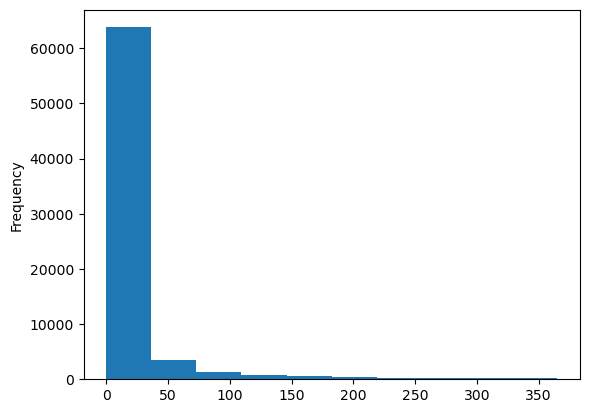

In [240]:
df_by_service1.Delay_in_days[df_by_service1.Delay_in_days<=365].plot(kind='hist')

In [243]:
df_by_service1[df_by_service1.Delay_in_days>30][["Service_ID","patient_age","Original_Carrier_Name","Service_Fee","Amount","Allowed","Transaction_Type"]]

,Service_ID,patient_age,Original_Carrier_Name,Service_Fee,Amount,Allowed,Transaction_Type
6,54819,50,BCBS of Michigan - Ep,8.0,8.00,NaN,1
12,57240,59,Blue Cross Complete (Medicaid),165.0,87.69,NaN,1
20,57605,71,Mclaren Health Plan,6.0,3.71,3.71,1
21,57606,71,Mclaren Health Plan,20.0,13.26,13.26,1
22,57607,71,Mclaren Health Plan,8.0,3.39,3.39,1
...,...,...,...,...,...,...,...
69608,5020591,68,Medicare Mr,220.0,114.20,131.14,2
69613,5020805,72,Medicare Mr,40.0,13.12,13.39,1
69635,5021393,75,Bcn Advantage,125.0,63.40,64.69,1
69646,5021487,30,Medicare Mr,40.0,13.12,13.39,1
